In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from keras.layers import Dense, Input
from keras.models import Model

from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler

np.random.seed(123)
tf.random.set_seed(123)

In [3]:
!curl -O https://lazyprogrammer.me/course_files/sp500sub.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  1 24.2M    1  414k    0     0   318k      0  0:01:18  0:00:01  0:01:17  318k
 24 24.2M   24 5990k    0     0  2360k      0  0:00:10  0:00:02  0:00:08 2361k
 31 24.2M   31 7926k    0     0  2321k      0  0:00:10  0:00:03  0:00:07 2321k
 40 24.2M   40  9.9M    0     0  2351k      0  0:00:10  0:00:04  0:00:06 2351k
 64 24.2M   64 15.6M    0     0  3102k      0  0:00:08  0:00:05  0:00:03 3214k
100 24.2M  100 24.2M    0     0  4447k      0  0:00:05  0:00:05 --:--:-- 5700k


In [4]:
df0 = pd.read_csv('sp500sub.csv', index_col='Date', parse_dates=True)
df = df0[df0['Name'] == 'SBUX'][['Close']].copy()
df['LogClose'] = np.log(df['Close'])
df['DiffLogClose'] = df['LogClose'].diff()

In [10]:
Ntest = 21
train = df.iloc[:-Ntest]
test = df.iloc[-Ntest:]

In [11]:
scalar = StandardScaler()
train_scaled = scalar.fit_transform(train[['DiffLogClose']])
test_scaled = scalar.fit_transform(test[['DiffLogClose']])

In [12]:
train_idx = df.index <= train.index[-1]
test_idx = ~train_idx

In [13]:
df.loc[train_idx, 'ScaledLogReturn'] = train_scaled.flatten()
df.loc[test_idx, 'ScaledLogReturn'] = test_scaled.flatten()

In [14]:
series = df['ScaledLogReturn'].dropna().to_numpy()

T = 10
X = [series[t:t+T] for t in range(len(series) - T)]
Y = [series[t+T] for t in range(len(series) - T)]

X = np.array(X).reshape(-1, T)
Y = np.array(Y)
N = len(X)
X.shape, Y.shape

((2252, 10), (2252,))

In [15]:
Xtrain, Xtest = X[:-Ntest], X[-Ntest:]
Ytrain, Ytest = Y[:-Ntest], Y[-Ntest:]

In [19]:
# Model
i = Input(shape=(T,))
x = Dense(32, activation='relu')(i)
x = Dense(1)(x)
model = Model(i, x)

model.compile(
    loss='mse',
    optimizer='adam'
)

In [20]:
r = model.fit(
    Xtrain, Ytrain, epochs=200,
    validation_data=(Xtest, Ytest)
)

Epoch 1/200
70/70 [==============================] - 0s 2ms/step - loss: 1.2362 - val_loss: 1.0926
Epoch 2/200
70/70 [==============================] - 0s 2ms/step - loss: 1.0776 - val_loss: 1.0175
Epoch 3/200
70/70 [==============================] - 0s 2ms/step - loss: 1.0358 - val_loss: 0.9879
Epoch 4/200
70/70 [==============================] - 0s 1ms/step - loss: 1.0163 - val_loss: 0.9696
Epoch 5/200
70/70 [==============================] - 0s 1ms/step - loss: 1.0046 - val_loss: 0.9614
Epoch 6/200
70/70 [==============================] - 0s 1ms/step - loss: 0.9952 - val_loss: 0.9505
Epoch 7/200
70/70 [==============================] - 0s 1ms/step - loss: 0.9883 - val_loss: 0.9478
Epoch 8/200
70/70 [==============================] - 0s 1ms/step - loss: 0.9819 - val_loss: 0.9325
Epoch 9/200
70/70 [==============================] - 0s 2ms/step - loss: 0.9765 - val_loss: 0.9436
Epoch 10/200
70/70 [==============================] - 0s 1ms/step - loss: 0.9725 - val_loss: 0.9332
Epoch 11/

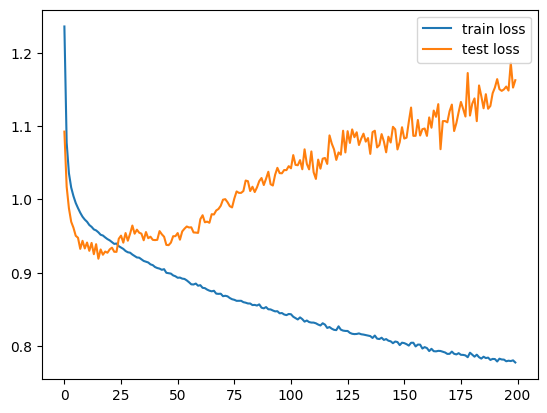

In [21]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

In [22]:
train_idx[:T+1] = False
Ptrain = model.predict(Xtrain)
Ptest = model.predict(Xtest)

Ptrain = scalar.inverse_transform(Ptrain).flatten()
Ptest = scalar.inverse_transform(Ptest).flatten()

1/1 [==============================] - 0s 15ms/step


In [23]:
df.loc[train_idx, 'Diff ANN Train Prediction'] = Ptrain
df.loc[test_idx, 'Diff ANN Test Prediction'] = Ptest

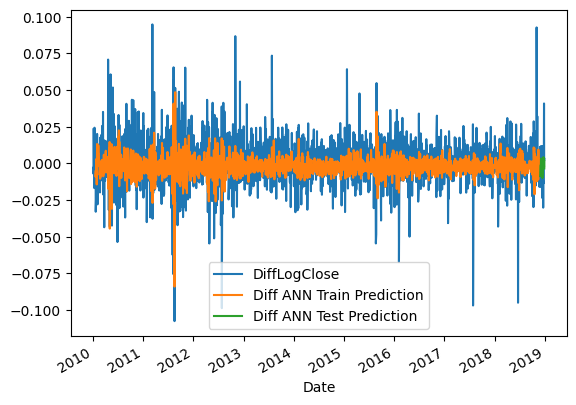

In [24]:
cols = ['DiffLogClose',
        'Diff ANN Train Prediction',
        'Diff ANN Test Prediction']
df[cols].plot();

In [25]:
df['ShiftLogClose'] = df['LogClose'].shift(1)
prev = df['ShiftLogClose']

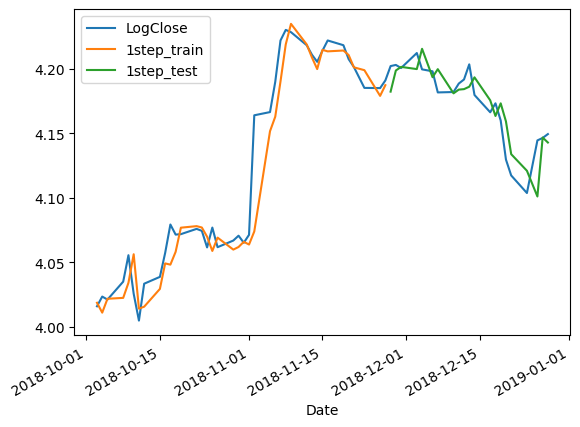

In [27]:
last_train = train.iloc[-1]['LogClose']
df.loc[train_idx, '1step_train'] = prev[train_idx] + Ptrain
df.loc[test_idx, '1step_test'] = prev[test_idx] + Ptest
df.iloc[-60:][['LogClose', '1step_train', '1step_test']].plot();

In [34]:
multistep_preds = []
last_x = Xtest[0]

while len(multistep_preds) < Ntest:
    p = model.predict(last_x.reshape(1, -1))[0]
    multistep_preds.append(p)
    
    last_x = np.roll(last_x, -1)
    last_x[-1] = p

1/1 [==============================] - ETA: 0s

C:\Users\zheng\AppData\Local\Temp\ipykernel_14064\3523322542.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  last_x[-1] = p


1/1 [==============================] - 0s 17ms/step


In [35]:
multistep_preds = np.array(multistep_preds)
multistep_preds = scalar.inverse_transform(
    multistep_preds
).reshape(1, -1)
multistep_preds

array([[-0.00866752, -0.00406019, -0.00393968, -0.00704989, -0.00181294,
         0.00254565, -0.00110442, -0.00516057, -0.00321516, -0.00088923,
        -0.00042543, -0.00294787, -0.00191359,  0.00014986, -0.00235378,
        -0.00439585, -0.00117187, -0.00069078, -0.00297456, -0.00361829,
        -0.00013443]], dtype=float32)

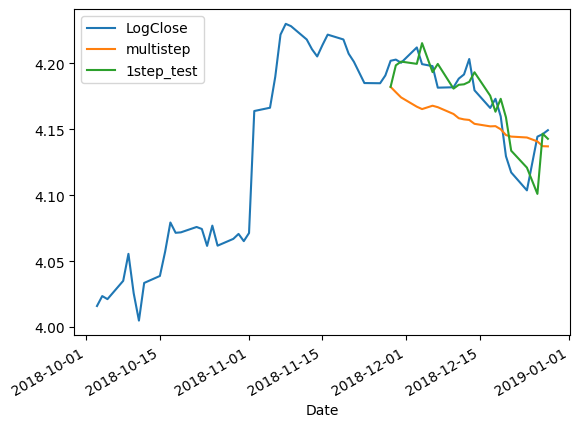

In [36]:
df.loc[test_idx, 'multistep'] = last_train + np.cumsum(multistep_preds)
df.iloc[-60:][['LogClose', 'multistep', '1step_test']].plot();

In [37]:
Tx = T
Ty = Ntest
X = [series[t:t+Tx] for t in range(len(series) - Tx - Ty + 1)]
Y = [series[t+Tx:t+Tx+Ty] for t in range(len(series) - Tx - Ty + 1)]

X = np.array(X).reshape(-1, Tx)
Y = np.array(Y).reshape(-1, Ty)
N = len(X)
X.shape, Y.shape

((2232, 10), (2232, 21))

In [38]:
Xtrain_m, Ytrain_m = X[:-1], Y[:-1]
Xtest_m, Ytest_m = X[-1:], Y[-1:]

In [40]:
i = Input(shape=(Tx,))
x = Dense(32, activation='relu')(i)
x = Dense(Ty)(x)
model = Model(i, x)

model.compile(
    loss='mse',
    optimizer='adam'
)

In [41]:
r = model.fit(
    Xtrain_m, Ytrain_m, epochs=100,
    validation_data=(Xtest_m, Ytest_m)
)

Epoch 1/100
70/70 [==============================] - 1s 6ms/step - loss: 1.1740 - val_loss: 0.9657
Epoch 2/100
70/70 [==============================] - 0s 4ms/step - loss: 1.0710 - val_loss: 0.9735
Epoch 3/100
70/70 [==============================] - 0s 3ms/step - loss: 1.0405 - val_loss: 0.9790
Epoch 4/100
70/70 [==============================] - 0s 3ms/step - loss: 1.0251 - val_loss: 0.9905
Epoch 5/100
70/70 [==============================] - 0s 3ms/step - loss: 1.0162 - val_loss: 0.9940
Epoch 6/100
70/70 [==============================] - 0s 3ms/step - loss: 1.0101 - val_loss: 0.9973
Epoch 7/100
70/70 [==============================] - 0s 3ms/step - loss: 1.0057 - val_loss: 1.0073
Epoch 8/100
70/70 [==============================] - 0s 3ms/step - loss: 1.0025 - val_loss: 1.0020
Epoch 9/100
70/70 [==============================] - 0s 3ms/step - loss: 0.9999 - val_loss: 1.0045
Epoch 10/100
70/70 [==============================] - 0s 2ms/step - loss: 0.9980 - val_loss: 1.0004
Epoch 11/

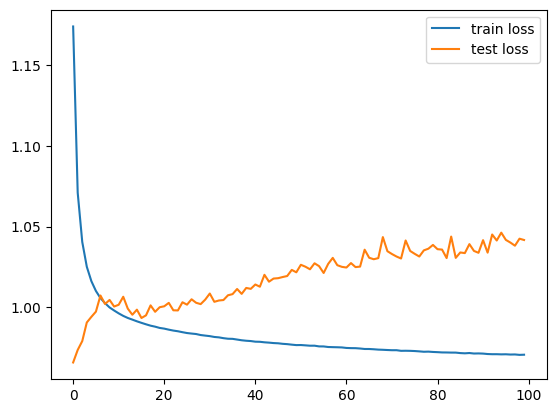

In [42]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

In [43]:
Ptrain = model.predict(Xtrain)
Ptest = model.predict(Xtest)

1/1 [==============================] - 0s 22ms/step


In [46]:
Ptest = Ptest[0]
Ptest = scalar.inverse_transform(Ptest.reshape(-1, 1)).flatten()

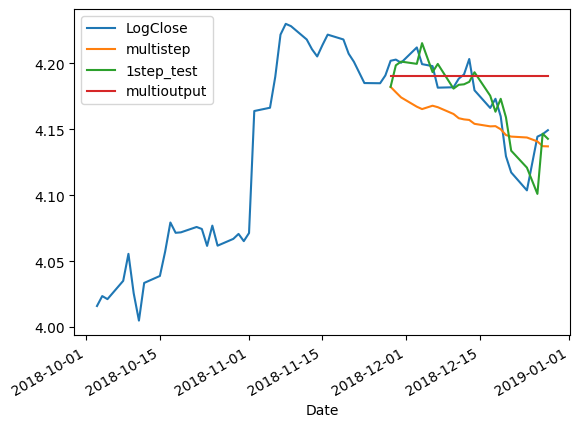

In [47]:
df.loc[test_idx, 'multioutput'] = last_train + np.cumsum(Ptest)
cols = ['LogClose', 'multistep', '1step_test', 'multioutput']
df.iloc[-60:][cols].plot();

In [48]:
# MAPE
test_log_pass = df.iloc[-Ntest:]['LogClose']
mape1 = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, 'multistep'])
print("multi-step MAPE:", mape1)
mape2 = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, 'multioutput'])
print("multi-output MAPE:", mape2)

multi-step MAPE: 0.0057446114697872535
multi-output MAPE: 0.006208134802114439


Try Classification

In [49]:
Ytrain_b = (Ytrain > 0) * 1
Ytest_b = (Ytest > 0) * 1

In [50]:
i = Input(shape=(T,))
x = Dense(32, activation='relu')(i)
x = Dense(1)(x)
model = Model(i, x)

model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=['accuracy'],
)

In [51]:
r = model.fit(
    Xtrain,
    Ytrain_b,
    epochs=100,
    validation_data=(Xtest, Ytest_b)
)

Epoch 1/100

70/70 [==============================] - 1s 4ms/step - loss: 0.7400 - accuracy: 0.5016 - val_loss: 0.7061 - val_accuracy: 0.4286
Epoch 2/100
70/70 [==============================] - 0s 2ms/step - loss: 0.7116 - accuracy: 0.5069 - val_loss: 0.6929 - val_accuracy: 0.4762
Epoch 3/100
70/70 [==============================] - 0s 3ms/step - loss: 0.7004 - accuracy: 0.5034 - val_loss: 0.6803 - val_accuracy: 0.4762
Epoch 4/100
70/70 [==============================] - 0s 3ms/step - loss: 0.6951 - accuracy: 0.5038 - val_loss: 0.6787 - val_accuracy: 0.4762
Epoch 5/100
70/70 [==============================] - 0s 3ms/step - loss: 0.6921 - accuracy: 0.5052 - val_loss: 0.6752 - val_accuracy: 0.4762
Epoch 6/100
70/70 [==============================] - 0s 3ms/step - loss: 0.6903 - accuracy: 0.5047 - val_loss: 0.6759 - val_accuracy: 0.4762
Epoch 7/100
70/70 [==============================] - 0s 3ms/step - loss: 0.6883 - accuracy: 0.5052 - val_loss: 0.6739 - val_accuracy: 0.4762
Epoch 8/100


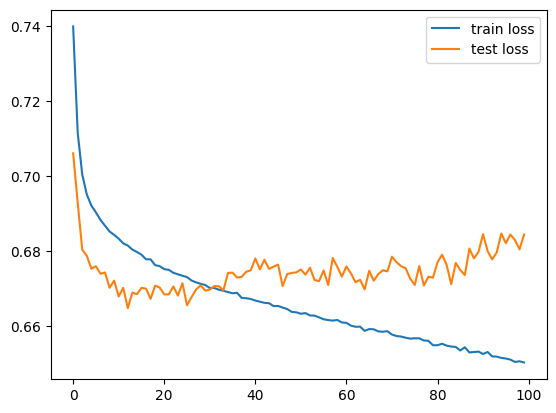

In [52]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

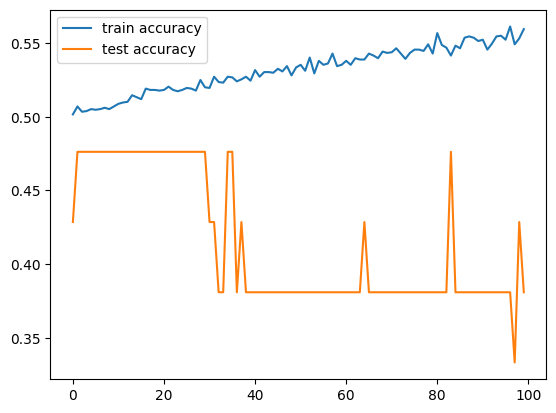

In [53]:
plt.plot(r.history['accuracy'], label='train accuracy')
plt.plot(r.history['val_accuracy'], label='test accuracy')
plt.legend();